# Drug Repurposing

In [1]:
import logging
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from matplotlib import gridspec
from openai import AzureOpenAI
from openpyxl.formatting.rule import ColorScaleRule, FormulaRule
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter
from tqdm import tqdm

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

_logger = logging.getLogger(__name__)

Read CSVs of nodes and edges.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)

_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/05/25 10:42:00] INFO     Number of nodes: 147020                                                ]8;id=340813;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2575215186.py\2575215186.py]8;;\:]8;id=165015;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2575215186.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=733128;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2575215186.py\2575215186.py]8;;\:]8;id=899418;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2575215186.py#7\7]8;;\

## Load KG and Model

Load knowledge graph.

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

Seed set to 42


Load model embeddings.

In [4]:
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)

### Utility Methods

Utility method to rank prediction lists.

In [5]:
def get_pred_ranks(preds):
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()
    sorted_indices = np.argsort(preds)
    return len(preds) - np.argsort(sorted_indices)

## Disease-Centric Splits

In [6]:
def strip_disease_tag(name: str) -> str:
    return name.replace(" (disease)", "")

Identify embeddings of all disease-centric models.

In [7]:
embeddings_files = list(Path(conf.paths.split_emb_dir).glob("*_embeddings.pt"))
test_sets = [int(file.stem.split("/")[-1].split("_embeddings")[0]) for file in embeddings_files]
test_sets_df = nodes[nodes["node_type"] == "disease"]
test_sets_df = test_sets_df[test_sets_df["node_index"].isin(test_sets)].reset_index(drop=True)

For each disease, make predictions using disease-centric models.

In [8]:
# Get all drug nodes
drug_nodes = nodes[nodes["node_type"] == "drug"].copy()

# Recall matrix
recall_df = pd.DataFrame()
recall_df["k"] = range(1, len(drug_nodes) + 1)

# Number of drugs
num_drugs_df = {}
num_diseases_df = {}
num_pos_drugs_df = {}

# For each disease
pbar = tqdm(test_sets_df.iterrows(), total=len(test_sets_df), desc="Making predictions")
for i, row in pbar:
    # Get disease index
    disease_index = row["node_index"]
    disease_name = row["node_name"]

    # Update progres bar description
    desc = f"Making predictions for {disease_name}"
    pbar.set_description(desc, refresh=True)

    # Get embedding file name
    embedding_file = next(file for file in embeddings_files if str(disease_index) in file.stem)
    decoder_file = str(embedding_file).replace("_embeddings", "_decoder")
    split_embeddings = torch.load(embedding_file)
    split_decoder = torch.tensor(torch.load(decoder_file))

    # Get split prediction
    # split_pred = drug_nodes.copy()
    src_ids = [disease_index] * len(drug_nodes)
    dst_ids = drug_nodes["node_index"].values
    indication_scores = pretrain_model.get_scores_from_embeddings(
        src_ids,
        dst_ids,
        ("disease", "indication", "drug"),
        embeddings=split_embeddings,
        decoder=split_decoder,
        query_kg=kg,
        use_cache=False,
    )

    # Store predictions and ranks
    indication_ranks = get_pred_ranks(indication_scores)
    drug_nodes[f"{disease_index}_scores"] = indication_scores.cpu().numpy()
    drug_nodes[f"{disease_index}_ranks"] = indication_ranks
    drug_nodes = drug_nodes.sort_values(by=f"{disease_index}_scores").reset_index(drop=True)

    # Read in disease split
    split_file = conf.paths.splits_dir / "split_edges_GPT" / f"{disease_index}.csv"
    split_edges = pd.read_csv(split_file)

    num_drugs_df[disease_name] = len(split_edges["y_index"].unique())
    num_diseases_df[disease_name] = len(split_edges["x_index"].unique())

    # Drop contraindications and weak clinical evidence edges
    split_edges = split_edges[split_edges["relation"] != "contraindication"]
    split_edges = split_edges[split_edges["relation"] != "weak_clinical_evidence"]
    num_pos_drugs_df[disease_name] = len(split_edges["y_index"].unique())

    # If no edges, skip
    if len(split_edges) == 0:
        _logger.info(f"No edges for {disease_name}")
        continue

    # Add ground truth
    drug_nodes[f"{disease_index}_ground_truth"] = 0
    for i, row in split_edges.iterrows():
        drug_nodes.loc[drug_nodes["node_index"] == row["y_index"], f"{disease_index}_ground_truth"] = 1

    # Plot predictions as rank vs. score
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        drug_nodes[f"{disease_index}_ranks"].values,
        drug_nodes[f"{disease_index}_scores"].values,
        color="black",
        linewidth=1.5,
        zorder=2,
    )
    ax.set_xlabel("Rank", fontsize=10)
    ax.set_ylabel("Score", fontsize=10)
    ax.set_xlim(0, len(drug_nodes))

    min_score = drug_nodes[f"{disease_index}_scores"].min()
    max_score = drug_nodes[f"{disease_index}_scores"].max()
    ax.set_ylim(min_score - 0.05, max_score + 0.05)

    # Add ground truth
    ground_truth_ranks = drug_nodes[drug_nodes[f"{disease_index}_ground_truth"] == 1].copy().reset_index(drop=True)
    palette = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    for i, row in ground_truth_ranks.iterrows():
        node_name = row["node_name"]
        node_color = palette[i % len(palette)]
        ax.axvline(x=row[f"{disease_index}_ranks"], color=node_color, linestyle="--", alpha=0.5, zorder=3)
        if i > 12:
            ax.scatter(row[f"{disease_index}_ranks"], row[f"{disease_index}_scores"], color=node_color, zorder=3)
        else:
            ground_truth_label = f"{node_name} ({100 * row[f'{disease_index}_ranks'] / len(drug_nodes):.2f}%)"
            ax.scatter(
                row[f"{disease_index}_ranks"],
                row[f"{disease_index}_scores"],
                color=node_color,
                label=node_name,
                zorder=3,
            )

    # Also calculate and plot recall at k
    ax2 = ax.twinx()
    recall_to_plot = []
    for k in range(len(drug_nodes)):
        num_ground_truth = len(ground_truth_ranks[ground_truth_ranks[f"{disease_index}_ranks"] <= k])
        recall = num_ground_truth / len(ground_truth_ranks)
        recall_to_plot.append(recall)
    recall_df[disease_name] = recall_to_plot

    ax2.plot(
        range(len(drug_nodes)),
        recall_to_plot,
        color="red",
        linestyle="-",
        label="Recall at $k$",
        zorder=2,
        linewidth=2,
        alpha=0.5,
    )
    ax2.set_ylabel("Recall at $k$ (%)", fontsize=10, color="red")
    ax2.set_ylim(-0.05, 1.05)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))

    ax.grid(True, linestyle=":", alpha=0.5, zorder=0)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=6, fontsize=8)
    plt.title(f"{disease_name}", fontsize=14, fontweight="bold")

    # Save plot
    plt.tight_layout()
    disease_name_clean = disease_name.replace(" (disease)", "").replace(" ", "_").replace("'", "").replace("-", "_")
    os.makedirs(conf.paths.notebooks.drug_repurposing_dir / "neuro_disease_splits", exist_ok=True)
    plt.savefig(
        conf.paths.notebooks.drug_repurposing_dir / "neuro_disease_splits" / f"{disease_name_clean}.pdf",
        bbox_inches="tight",
    )
    plt.close()

# Convert counters to dataframe
num_drugs_df = pd.DataFrame.from_dict(num_drugs_df, orient="index")
num_drugs_df.columns = ["num_drugs"]
num_diseases_df = pd.DataFrame.from_dict(num_diseases_df, orient="index")
num_diseases_df.columns = ["num_diseases"]
num_pos_drugs_df = pd.DataFrame.from_dict(num_pos_drugs_df, orient="index")
num_pos_drugs_df.columns = ["num_drugs"]

Making predictions for craniopharyngioma:  24%|██████████████▋                                              | 6/25 [00:06<00:17,  1.06it/s]

[12/05/25 10:42:21] INFO     No edges for craniopharyngioma                                        ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2080374027.py\2080374027.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2080374027.py#64\64]8;;\

Making predictions for Charcot-Marie-Tooth disease: 100%|██████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.01s/it]


Read in GPT-reviewed disease splits.

In [9]:
disease_splits = pd.read_csv(conf.paths.splits_dir / "disease_splits_GPT.csv")
disease_splits = disease_splits[disease_splits["disease_split_index"].isin(test_sets)]

Note, although we initially constructed disease-centric splits for 25 neurological diseases, several of these diseases had insufficient drug evidence for meaningful evaluation. Specifically, we excluded any disease that had fewer than five drugs supported by indication, strong clinical evidence, or off-label use evidence. After applying this criterion, 17 neurological diseases remained and constituted the final evaluation set.

In [10]:
# The k values we want to compare
k_values = [0.05, 0.1, 0.15, 0.20, 0.25]
k_values = [round(k * len(drug_nodes)) for k in k_values]
recall_subset = recall_df[recall_df["k"].isin(k_values)].set_index("k").T

# Ensure the columns appear in ascending order of k
recall_subset = recall_subset[k_values]
full_recall_subset = recall_subset.copy()

# Keep only diseases that have at least 5 drugs in (indication, strong clinical evidence, off-label use)
eval_diseases = num_pos_drugs_df[num_pos_drugs_df["num_drugs"] >= 5].index
recall_subset = recall_subset.loc[recall_subset.index.intersection(eval_diseases)]

# Sort diseases by their recall at k=25%
recall_subset = recall_subset.sort_values(by=k_values[::-1], ascending=False)

In [11]:
# Print stats
eval_diseases = [x.replace(" (disease)", "") for x in eval_diseases]
disease_splits = disease_splits[disease_splits["disease_split"].isin(eval_diseases)]
num_included = sum(disease_splits["gpt_eval"] == "Yes")
num_discarded = sum(disease_splits["gpt_eval"] == "No")
num_total = disease_splits.shape[0]
_logger.info(f"Number of diseases: {len(disease_splits['disease_split_index'].unique())}")
_logger.info(f"Number of included: {num_included}")
_logger.info(f"Number of discarded: {num_discarded}")
_logger.info(f"Number of total: {num_total}")

# Mean and SD number of diseases per split
full_num_diseases = disease_splits[disease_splits["gpt_eval"] == "Yes"]["disease_split"].value_counts()
mean_num_diseases = full_num_diseases.mean()
sd_num_diseases = full_num_diseases.std()
full_num_diseases_df = full_num_diseases.to_frame()
_logger.info(f"Mean number of diseases: {mean_num_diseases:.2f}")
_logger.info(f"SD number of diseases: {sd_num_diseases:.2f}")

[12/05/25 10:43:06] INFO     Number of diseases: 17                                                 ]8;id=91161;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=619176;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#7\7]8;;\

                    INFO     Number of included: 453                                                ]8;id=243962;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=529903;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#8\8]8;;\

                    INFO     Number of discarded: 162                                               ]8;id=681453;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=735392;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#9\9]8;;\

                    INFO     Number of total: 615                                                  ]8;id=291704;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=848749;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#10\10]8;;\

                    INFO     Mean number of diseases: 26.65                                        ]8;id=732052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=443143;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#17\17]8;;\

                    INFO     SD number of diseases: 27.37                                          ]8;id=352944;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py\3687684620.py]8;;\:]8;id=107175;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3687684620.py#18\18]8;;\

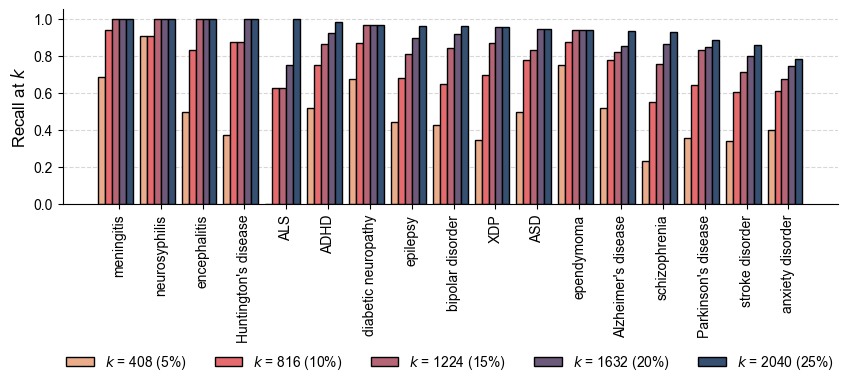

In [12]:
short_disease_names = {
    "attention deficit-hyperactivity disorder": "ADHD",
    "amyotrophic lateral sclerosis": "ALS",
    "autism spectrum disorder": "ASD",
    "X-linked dystonia-parkinsonism": "XDP",
    "Alzheimer disease": "Alzheimer's disease",
    "Parkinson disease": "Parkinson's disease",
    "Huntington disease": "Huntington's disease",
}

# X-coordinates for each disease
disease_names = recall_subset.index
diseases = []
for disease in disease_names:
    num_drugs = num_drugs_df.loc[disease, "num_drugs"]
    if disease in short_disease_names:
        disease = short_disease_names[disease]
    # diseases.append(f"{disease} ({num_drugs})")
    diseases.append(disease)
diseases = [disease.replace(" (disease)", "") for disease in diseases]
x = np.arange(len(diseases))

# Width for each bar in the group
bar_width = 1.0 / (len(k_values) + 1)
fig, ax = plt.subplots(figsize=(10, 3))

# Plot a bar for each k-value
k_colors = ["#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"][::-1]
for i, k in enumerate(k_values):
    frac_value = k / len(drug_nodes) * 100
    k_label = f"$k$ = {k} ({frac_value:.0f}%)"

    ax.bar(
        x + i * bar_width,
        recall_subset[k],
        width=bar_width,
        label=k_label,
        color=k_colors[i],
        edgecolor="black",
        zorder=2,
    )

ax.set_xticks(x + bar_width * (len(k_values) / 2))
ax.set_xticklabels(diseases, rotation=90, fontsize=10)

# Make legend above plot
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.85),
#           ncol=len(k_values), fontsize=10, frameon=False)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.7), ncol=len(k_values), fontsize=10, frameon=False)

# ax.set_xlabel("Disease", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Recall at ${k}$", fontsize=12)

# Make grid for y axis only
ax.grid(True, linestyle="--", alpha=0.5, zorder=0, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# plt.tight_layout()
plt.subplots_adjust(bottom=0.23)

# Save plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k.svg", bbox_inches="tight")

plt.show()

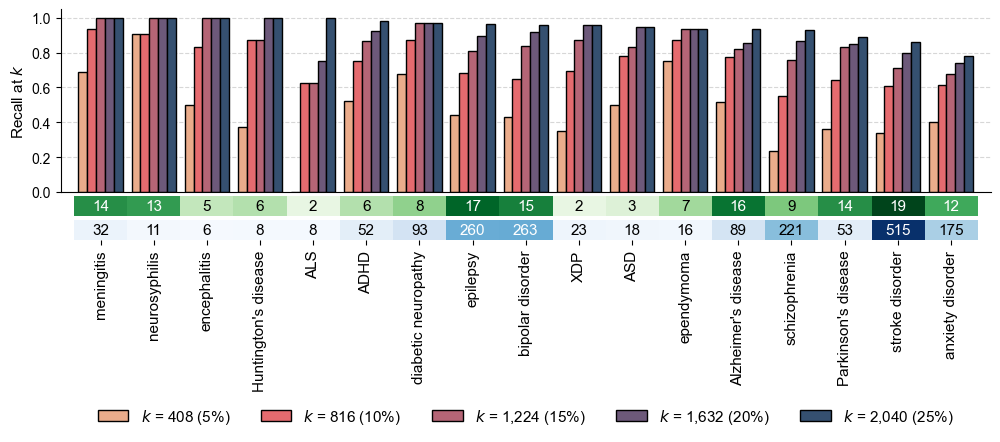

In [13]:
# Assemble data for heatmap
disease_names = recall_subset.index
n_diseases_array = num_diseases_df.loc[disease_names, "num_diseases"].values
n_drugs_array = num_pos_drugs_df.loc[disease_names, "num_drugs"].values
x = np.arange(len(disease_names))  # * spacing
bar_width = 1.0 / (len(k_values) + 1)

# Layout heatmap
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(
    nrows=3,
    ncols=1,
    height_ratios=[2.7, 0.3, 0.3],  # bars, heat-map row1, heat-map row2
    hspace=0.05,
)

ax_bar = fig.add_subplot(gs[0])
ax_hm_dis = fig.add_subplot(gs[1], sharex=ax_bar)
ax_hm_drug = fig.add_subplot(gs[2], sharex=ax_bar)
plt.setp(ax_bar.get_xticklabels(), visible=False)
plt.setp(ax_hm_dis.get_xticklabels(), visible=False)

# Bar chart
k_colors = ["#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"][::-1]
group_width = len(k_values) * bar_width  # total width of one bundle
half_width = group_width / 2

for i, k in enumerate(k_values):
    frac_value = k / len(drug_nodes) * 100
    label = rf"$k$ = {k:,} ({frac_value:.0f}%)"

    ax_bar.bar(
        x - half_width + i * bar_width + bar_width / 2,
        recall_subset[k],
        width=bar_width,
        label=label,
        color=k_colors[i],
        edgecolor="black",
        zorder=2,
    )

ax_bar.set_ylabel("Recall at $k$", fontsize=11)
ax_bar.legend(loc="upper center", bbox_to_anchor=(0.5, -1.1), ncol=len(k_values), fontsize=11, frameon=False)
ax_bar.grid(True, axis="y", linestyle="--", alpha=0.5, zorder=0)
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)

# Disable major and minor ticks
ax_bar.tick_params(axis="x", which="both", bottom=False, top=False)

# Heatmap for number of diseases
cmap_dis = mpl.cm.Greens
norm_dis = mpl.colors.Normalize(vmin=0, vmax=n_diseases_array.max())

im_dis = ax_hm_dis.imshow(
    n_diseases_array.reshape(1, -1), aspect="auto", cmap=cmap_dis, norm=norm_dis, interpolation="nearest"
)

ax_hm_dis.set_yticks([])
ax_hm_dis.tick_params(axis="x", length=0)  # suppress tiny ticks
for spine in ax_hm_dis.spines.values():
    spine.set_visible(False)

# Annotate with adaptive text colour
for j, val in enumerate(n_diseases_array):
    text_col = "white" if norm_dis(val) >= 0.5 else "black"
    ax_hm_dis.text(j, 0, val, ha="center", va="center", fontsize=11, color=text_col)

# Heatmap for number of drugs
cmap_drug = mpl.cm.Blues
norm_drug = mpl.colors.Normalize(vmin=0, vmax=n_drugs_array.max())

im_drug = ax_hm_drug.imshow(
    n_drugs_array.reshape(1, -1), aspect="auto", cmap=cmap_drug, norm=norm_drug, interpolation="nearest"
)

ax_hm_drug.set_yticks([])

# X-tick positions and labels (group centres)
# group_centres = x + bar_width * (len(k_values) / 2)
pretty_names = [short_disease_names.get(name, name).replace(" (disease)", "") for name in disease_names]
# ax_hm_drug.set_xticks(group_centres)
ax_hm_drug.set_xticks(x)
ax_hm_drug.set_xticklabels(pretty_names, rotation=90, fontsize=11)

for spine in ax_hm_drug.spines.values():
    spine.set_visible(False)

for j, val in enumerate(n_drugs_array):
    text_col = "white" if norm_drug(val) >= 0.5 else "black"
    ax_hm_drug.text(j, 0, val, ha="center", va="center", fontsize=11, color=text_col)

# Ensure both axes cover exactly the same horizontal range
ax_bar.set_xlim(x[0] - 0.75, x[-1] + 0.75)

# plt.tight_layout()
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k_with_heatmap.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k_with_heatmap.svg", bbox_inches="tight")
plt.show()

Compute statistics.

In [15]:
# Compute mean and SD of recall at k values of interest
mean_recall_at_k = full_recall_subset.mean(axis=0)
sd_recall_at_k = full_recall_subset.std(axis=0)
k_pers = [k / len(drug_nodes) * 100 for k in k_values]
recall_at_k_df = pd.DataFrame({"per": k_pers, "mean": mean_recall_at_k, "sd": sd_recall_at_k})
recall_at_k_df

,per,mean,sd
k,,,
408,5.0,0.478687,0.309913
816,10.0,0.756932,0.226056
1224,15.0,0.892431,0.117392
1632,20.0,0.933412,0.082981
2040,25.0,0.962363,0.054703


## Bipolar Disorder Split

In [16]:
HIGHLIGHT_DISEASE = "bipolar disorder"

h_index = nodes[nodes["node_name"] == HIGHLIGHT_DISEASE]["node_index"].values[0]
h_drug_preds = drug_nodes[
    ["node_index", "node_id", "node_name", f"{h_index}_scores", f"{h_index}_ranks", f"{h_index}_ground_truth"]
].copy()

# Add rank percentage column
h_drug_preds["rank_pct"] = h_drug_preds[f"{h_index}_ranks"] / len(h_drug_preds) * 100

# Add nodes only indicated for target disease(and not rest of split)
h_indications = edges[(edges["relation"] == "indication") & (edges["x_index"] == h_index)]["y_index"].unique()
h_off_label_use = edges[(edges["relation"] == "off_label_use") & (edges["x_index"] == h_index)]["y_index"].unique()
h_strong_clin_ev = edges[(edges["relation"] == "strong_clin_ev") & (edges["x_index"] == h_index)]["y_index"].unique()

# Rename columns
h_drug_preds = h_drug_preds.rename(
    {f"{h_index}_ranks": "rank", f"{h_index}_scores": "score", f"{h_index}_ground_truth": "ground_truth"}, axis=1
)

# For each drug, check if it is indicated
h_drug_preds["indications"] = h_drug_preds["node_index"].isin(h_indications)
h_drug_preds["off_label_use"] = h_drug_preds["node_index"].isin(h_off_label_use)
h_drug_preds["strong_clin_ev"] = h_drug_preds["node_index"].isin(h_strong_clin_ev)
h_drug_preds = h_drug_preds.sort_values(by="score", ascending=False)

In [17]:
def compute_recall_at_k(df, label_col, k):
    top_k = df.head(k)
    true_positives = top_k[label_col].sum()
    total_positives = df[label_col].sum()
    recall = true_positives / total_positives if total_positives > 0 else 0
    return recall


# Choose your cutoffs
h_k_values = [0.05, 0.1, 0.15, 0.20, 0.25]
h_k_values = [round(k * len(h_drug_preds)) for k in h_k_values]

# Compute recall@k for indications and off-label use
recall_at_k_results = []

for k in h_k_values:
    recall_indications = compute_recall_at_k(h_drug_preds, "indications", k)
    recall_off_label = compute_recall_at_k(h_drug_preds, "off_label_use", k)
    recall_strong_clin_ev = compute_recall_at_k(h_drug_preds, "strong_clin_ev", k)
    recall_at_k_results.append({
        "k": k,
        "recall@k_indications": recall_indications,
        "recall@k_off_label_use": recall_off_label,
        "recall@k_strong_clin_ev": recall_strong_clin_ev,
    })

recall_at_k_df = pd.DataFrame(recall_at_k_results)
_logger.info(recall_at_k_df)

[12/05/25 10:49:40] INFO           k  recall@k_indications  recall@k_off_label_use                 ]8;id=633052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3793527054.py\3793527054.py]8;;\:]8;id=277370;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3793527054.py#28\28]8;;\
                             recall@k_strong_clin_ev                                                               
                             0   408               0.68750                0.842105                                 
                             0                                                                                     
                             1   816               0.81250                0.947368                                 
                             0                                                                                     
                             2  1224               0.84375                0.947368                                 
                             0                                                                                     
                             3  1632               0.93750                0.947368                                 
                             0                                                                                     
                             4  2040               0.96875                1.000000                                 
                             0                                                                                     

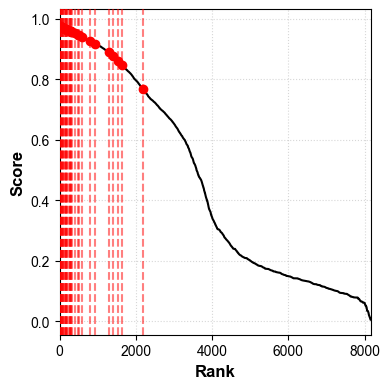

In [18]:
# Create the plot
plt.figure(figsize=(4, 4))
plt.plot(h_drug_preds["rank"].values, h_drug_preds["score"].values, color="black", linewidth=1.5, zorder=2)

# Set labels and limits
plt.xlabel("Rank", fontsize=12, fontweight="bold")
plt.ylabel("Score", fontsize=12, fontweight="bold")
plt.xlim(0, len(h_drug_preds))
min_score = h_drug_preds["score"].min()
max_score = h_drug_preds["score"].max()
plt.ylim(min_score - 0.05, max_score + 0.05)

# Define color palette
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Add ground truth
ground_truth = h_drug_preds[(h_drug_preds["indications"] == 1)].copy().reset_index(drop=True)
z_value = ground_truth.shape[0] + 10
for i, row in ground_truth.iterrows():
    node_name = row["node_name"]
    # # node_color = palette[i % len(palette)] if i < len(palette) else "gray"
    # node_color = palette[i % len(palette)]
    node_label = f"#{row['rank']}: {node_name} (top {row['rank_pct']:.2f}%)"
    node_color = "red"
    plt.axvline(x=row["rank"], color=node_color, linestyle="--", alpha=0.5, zorder=z_value)
    plt.scatter(row["rank"], row["score"], color=node_color, label=node_label, zorder=z_value)
    z_value = z_value - 1

# Add grid and legend
plt.grid(True, linestyle=":", alpha=0.5, zorder=0)
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=4, fontsize=8)
# plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "BD_split_performance.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "BD_split_performance.svg", bbox_inches="tight")
plt.show()
# plt.close()

## Final Predictions

Make final predictions using the model trained on the full KG.

In [20]:
# Get drug nodes and degree lists
drug_nodes = nodes[nodes["node_type"] == "drug"].copy()
drug_degrees = []

# Get indication and contraindication edges
indications = edges[edges["relation"] == "indication"]
contraindications = edges[edges["relation"] == "contraindication"]

# Group by y_index, i.e., drug ID
indications_by_drug = indications.groupby("y_index")["x_index"].apply(list).reset_index()
contraindications_by_drug = contraindications.groupby("y_index")["x_index"].apply(list).reset_index()

# Print results
_logger.info(f"Number of drugs: {len(drug_nodes)}")
_logger.info(f"Number of drugs with >= 1 indication: {len(indications_by_drug)}")
_logger.info(f"Number of drugs with >= 1 contraindication: {len(contraindications_by_drug)}")

# Compute degree for each drug node
for drug in tqdm(drug_nodes["node_index"], desc="Computing drug degree", total=len(drug_nodes)):
    # Get degree from number of edges in CSV
    drug_edges = edges[edges["x_index"] == drug]
    drug_degrees.append(len(drug_edges))

# Add degrees to drug nodes
drug_nodes["degree"] = drug_degrees

# Merge with indications and contraindications
drug_nodes = drug_nodes.merge(indications_by_drug, left_on="node_index", right_on="y_index", how="left")
drug_nodes = drug_nodes.rename(columns={"x_index": "indications"})
drug_nodes = drug_nodes.drop(columns="y_index")
drug_nodes = drug_nodes.merge(contraindications_by_drug, left_on="node_index", right_on="y_index", how="left")
drug_nodes = drug_nodes.rename(columns={"x_index": "contraindications"})
drug_nodes = drug_nodes.drop(columns="y_index")

# Replace NaN with empty lists
drug_nodes["indications"] = drug_nodes["indications"].apply(lambda x: x if isinstance(x, list) else [])
drug_nodes["contraindications"] = drug_nodes["contraindications"].apply(lambda x: x if isinstance(x, list) else [])

[12/05/25 10:53:34] INFO     Number of drugs: 8160                                                 ]8;id=967096;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py\3241443025.py]8;;\:]8;id=396922;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py#14\14]8;;\

                    INFO     Number of drugs with >= 1 indication: 2201                            ]8;id=648564;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py\3241443025.py]8;;\:]8;id=928463;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py#15\15]8;;\

                    INFO     Number of drugs with >= 1 contraindication: 1283                      ]8;id=72933;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py\3241443025.py]8;;\:]8;id=48050;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3241443025.py#16\16]8;;\

Computing drug degree: 100%|██████████████████████████████████████████████████████████████████████████| 8160/8160 [00:49<00:00, 166.40it/s]


Create data frame of disease nodes.

In [21]:
# Get disease nodes
disease_nodes = nodes[nodes["node_type"] == "disease"].copy()
disease_degrees = []

# Add indications and contraindications
indications_by_disease = indications.groupby("x_index")["y_index"].apply(list).reset_index()
contraindications_by_disease = contraindications.groupby("x_index")["y_index"].apply(list).reset_index()

# Print results
_logger.info(f"Number of diseases: {len(disease_nodes)}")
_logger.info(f"Number of diseases with >= 1 indication: {len(indications_by_disease)}")
_logger.info(f"Number of diseases with >= 1 contraindication: {len(contraindications_by_disease)}")

# Compute degree for each drug node
for drug in tqdm(disease_nodes["node_index"], desc="Computing disease degree", total=len(disease_nodes)):
    # Get degree from number of edges in CSV
    disease_edges = edges[edges["x_index"] == drug]
    disease_degrees.append(len(disease_edges))

# Add degrees to disease nodes
disease_nodes["degree"] = disease_degrees

# Merge with indications and contraindications
disease_nodes = disease_nodes.merge(indications_by_disease, left_on="node_index", right_on="x_index", how="left")
disease_nodes = disease_nodes.rename(columns={"y_index": "indications"})
disease_nodes = disease_nodes.drop(columns="x_index")
disease_nodes = disease_nodes.merge(contraindications_by_disease, left_on="node_index", right_on="x_index", how="left")
disease_nodes = disease_nodes.rename(columns={"y_index": "contraindications"})
disease_nodes = disease_nodes.drop(columns="x_index")

# Replace NaN with empty list
disease_nodes["indications"] = disease_nodes["indications"].apply(lambda x: x if isinstance(x, list) else [])
disease_nodes["contraindications"] = disease_nodes["contraindications"].apply(
    lambda x: x if isinstance(x, list) else []
)

[12/05/25 10:54:24] INFO     Number of diseases: 22201                                             ]8;id=244098;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py\3305556592.py]8;;\:]8;id=908573;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py#10\10]8;;\

                    INFO     Number of diseases with >= 1 indication: 1969                         ]8;id=874628;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py\3305556592.py]8;;\:]8;id=382554;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py#11\11]8;;\

                    INFO     Number of diseases with >= 1 contraindication: 1280                   ]8;id=279946;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py\3305556592.py]8;;\:]8;id=735911;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/3305556592.py#12\12]8;;\

Computing disease degree: 100%|█████████████████████████████████████████████████████████████████████| 22201/22201 [02:32<00:00, 145.87it/s]


Add combined disease splits.

In [22]:
# Read disease splits
disease_splits = pd.read_csv(conf.paths.splits_dir / "disease_splits_GPT.csv")
disease_splits = disease_splits[disease_splits["gpt_eval"] == "Yes"]
split_indications = {}
split_contraindications = {}

# Iterate over splits
split_groups = disease_splits.groupby("disease_split_index")

for split_index, split_group in split_groups:
    # Merge indications and contraindications for diseases in split
    split_diseases = split_group["node_index"].values
    assert split_index in split_diseases

    indications_list = disease_nodes[disease_nodes["node_index"].isin(split_diseases)]["indications"].values
    indications_list = list({item for sublist in indications_list for item in sublist})

    contraindications_list = disease_nodes[disease_nodes["node_index"].isin(split_diseases)]["contraindications"].values
    contraindications_list = list({item for sublist in contraindications_list for item in sublist})

    # Store in dictionary
    split_indications[split_index] = indications_list
    split_contraindications[split_index] = contraindications_list

# Add indications and contraindications to disease nodes
disease_nodes["split_indications"] = disease_nodes["node_index"].map(split_indications)
disease_nodes["split_contraindications"] = disease_nodes["node_index"].map(split_contraindications)

# Replace NaN with empty list
disease_nodes["split_indications"] = disease_nodes["split_indications"].apply(
    lambda x: x if isinstance(x, list) else []
)
disease_nodes["split_contraindications"] = disease_nodes["split_contraindications"].apply(
    lambda x: x if isinstance(x, list) else []
)

Add disease subset information.

In [23]:
# Add column indicating subset
disease_nodes["subset"] = None
disease_nodes.loc[disease_nodes["node_index"].isin(test_sets), "subset"] = "neuro_disease_splits"

### Predictions

Make predictions for neurological disorders.

In [ ]:
preds = {
    "drugs": drug_nodes.copy(),  # .reset_index(drop=True)
    "diseases": disease_nodes.copy(),  # .reset_index(drop=True)
    "scores": {},
    "ranks": {},
}

disease_iters = disease_nodes[~disease_nodes["subset"].isna()]
pbar_length = len(disease_iters)
disease_iters = zip(disease_iters["node_name"], disease_iters["node_index"], strict=False)

pbar = tqdm(disease_iters, desc="Computing predictions for diseases", total=pbar_length, leave=True)
for disease_name, disease_index in pbar:
    # Print disease name
    # _logger.info(f"Selected disease: {disease_name}")
    pbar.set_description(f"Predicting for {disease_name}", refresh=True)
    disease_scores = preds["drugs"][["node_index"]].copy().reset_index(drop=True)
    disease_ranks = preds["drugs"][["node_index"]].copy().reset_index(drop=True)

    # Get indication predictions
    src_ids = [disease_index] * len(drug_nodes)
    dst_ids = drug_nodes["node_index"].values
    indication_scores = pretrain_model.get_scores_from_embeddings(
        src_ids, dst_ids, ("disease", "indication", "drug"), embeddings=embeddings, query_kg=kg, use_cache=False
    )

    # Store predictions and ranks
    indication_ranks = get_pred_ranks(indication_scores)
    disease_scores["indication"] = indication_scores.cpu().numpy()
    disease_ranks["indication"] = indication_ranks

    # Add to predictions object
    preds["scores"][disease_index] = disease_scores
    preds["ranks"][disease_index] = disease_ranks

Predicting for Charcot-Marie-Tooth disease: 100%|██████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 42.34it/s]


### Prediction Correlation Heatmap

Assess whether predictions are consistent across clinically related diseases.

In [30]:
score_df = preds["drugs"].copy()
rank_df = preds["drugs"].copy()
for key, value in preds["scores"].items():
    score_df[key] = value["indication"]
for key, value in preds["ranks"].items():
    rank_df[key] = value["indication"]

In [31]:
high_ranked = rank_df[test_sets].T.apply(lambda x: sum(x <= 2000) >= 1)
_logger.info("Total high-ranked drugs: %s", sum(high_ranked))
rank_df = rank_df[high_ranked]

[12/05/25 11:13:28] INFO     Total high-ranked drugs: 3071                                          ]8;id=179451;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2711234544.py\2711234544.py]8;;\:]8;id=560086;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/2711234544.py#2\2]8;;\

In [32]:
group_mapping = {
    "medulloblastoma": "cancer",
    "autism spectrum disorder": "neuropsychiatric",
    "Charcot-Marie-Tooth disease": "other",
    "anxiety disorder": "neuropsychiatric",
    "Down syndrome": "other",
    "Parkinson disease": "neurodegenerative",
    "stroke disorder": "neurodegenerative",
    "epilepsy": "neuropsychiatric",
    "brain astrocytoma": "cancer",
    "bipolar disorder": "neuropsychiatric",
    "neurosyphilis": "infectious",
    "Huntington disease": "neurodegenerative",
    "schizophrenia": "neuropsychiatric",
    "brain oligodendroglioma": "cancer",
    "encephalitis": "infectious",
    "X-linked dystonia-parkinsonism": "neurodegenerative",
    "craniopharyngioma": "cancer",
    "brain meningioma": "cancer",
    "ependymoma": "cancer",
    "amyotrophic lateral sclerosis": "neurodegenerative",
    "progressive supranuclear palsy": "neurodegenerative",
    "Alzheimer disease": "neurodegenerative",
    "meningitis": "infectious",
    "diabetic neuropathy": "other",
    "ADHD": "neuropsychiatric",
}

group_colors = {
    "neurodegenerative": "#ef476f",
    "neuropsychiatric": "#ffd166",
    "cancer": "#06d6a0",
    "infectious": "#118ab2",
    "other": "gray",
}

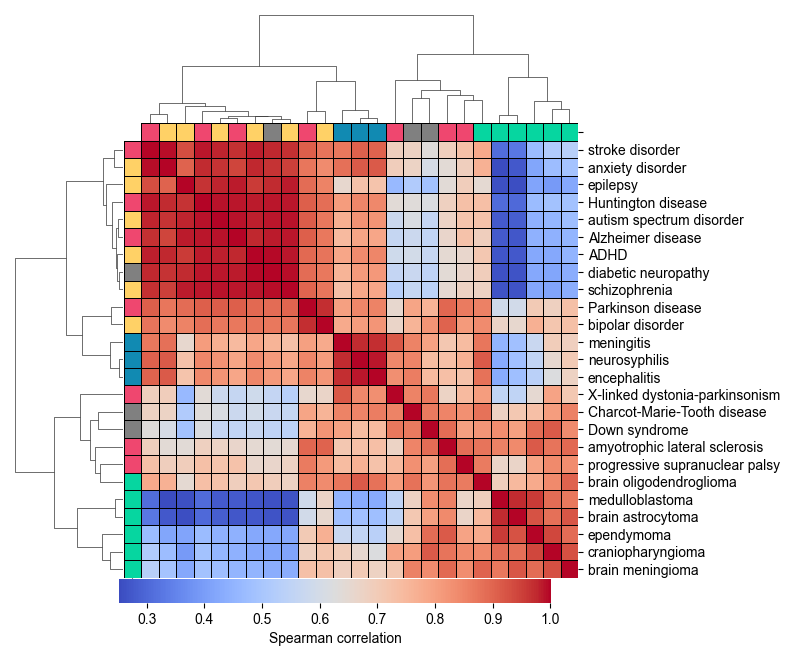

In [ ]:
corr_matrix = rank_df[test_sets].corr()
disease_names = []
for disease_index in test_sets:
    disease_name = disease_nodes[disease_nodes["node_index"] == disease_index]["node_name"].values[0]
    disease_name = disease_name.replace(" (disease)", "")
    if disease_name == "attention deficit-hyperactivity disorder":
        disease_name = "ADHD"
    disease_names.append(disease_name)
corr_matrix.index = disease_names
corr_matrix.columns = disease_names

# Create group labels
group_labels = [group_mapping[disease] for disease in disease_names]
row_colors = pd.Series(group_labels, index=disease_names).map(group_colors)

# Create heatmap with hierarchical clustering
g = sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="black",
    vmax=1.001,
    cbar_kws={"label": "Spearman correlation", "orientation": "horizontal"},
    cbar_pos=(0.155, 0.24, 0.54, 0.03),  # (left, bottom, width, height)
    figsize=(8, 8),
    row_colors=row_colors,
    col_colors=row_colors,
)
# g.cax.set_orientation('horizontal')
g.ax_heatmap.tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=False)

# Save plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "top_prediction_correlation.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "top_prediction_correlation.svg", bbox_inches="tight")

plt.show()

## Evaluate Disease Predictions

In [34]:
# AD: 42049
# PD: 39579
# BD: 39528
DISEASE_ID = 39528
DISEASE_NAME = preds["diseases"][preds["diseases"]["node_index"] == DISEASE_ID]["node_name"].values[0]
CLEAN_DISEASE_NAME = DISEASE_NAME.replace(" ", "_")
DISEASE_DIR = conf.paths.notebooks.drug_repurposing_dir / "disease_predictions" / CLEAN_DISEASE_NAME
_logger.info(f"Disease: {DISEASE_NAME}\nID: {DISEASE_ID}")

# If disease directory does not exist, create it
if not os.path.exists(DISEASE_DIR):
    os.makedirs(DISEASE_DIR)

disease_preds = pd.merge(preds["drugs"], preds["scores"][DISEASE_ID], on="node_index", how="left", sort=False)
disease_preds.sort_values("indication", ascending=False, inplace=True)

# Add rank column
disease_preds["indication_rank"] = get_pred_ranks(disease_preds["indication"])
disease_preds["indication_rank_pct"] = 100 * disease_preds["indication_rank"] / len(disease_preds)

# Get BD predictions for which BD is an indication
disease_indications = disease_nodes[disease_nodes["node_index"] == DISEASE_ID]["indications"].values[0]
disease_indications = [nodes[nodes["node_index"] == ind]["node_name"].values[0] for ind in disease_indications]
disease_indications = disease_preds[disease_preds["node_name"].isin(disease_indications)]

[12/05/25 11:14:02] INFO     Disease: bipolar disorder                                              ]8;id=970342;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/1399209822.py\1399209822.py]8;;\:]8;id=671088;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_49140/1399209822.py#8\8]8;;\
                             ID: 39528                                                                             

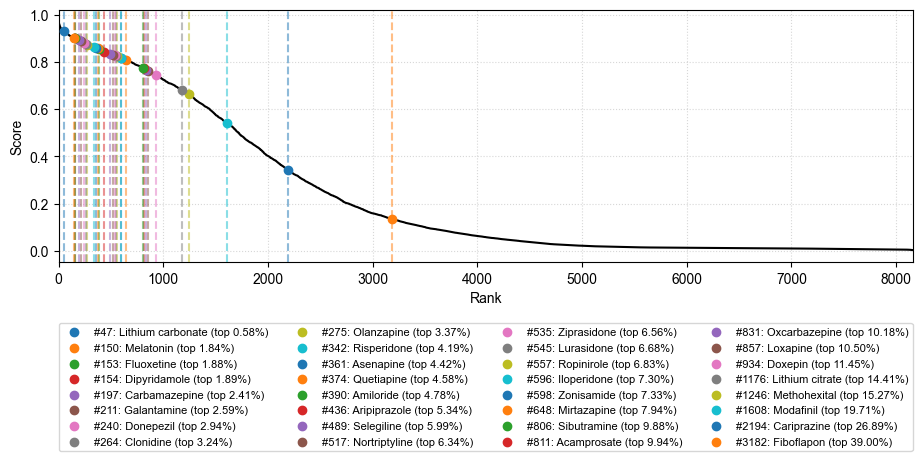

In [35]:
# Create the plot
plt.figure(figsize=(9.8, 5))
plt.plot(
    disease_preds["indication_rank"].values, disease_preds["indication"].values, color="black", linewidth=1.5, zorder=2
)

# Set labels and limits
plt.xlabel("Rank", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.xlim(0, len(disease_preds))
min_score = disease_preds["indication"].min()
max_score = disease_preds["indication"].max()
plt.ylim(min_score - 0.05, max_score + 0.05)

# Define color palette
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Add ground truth
ground_truth = disease_indications.copy().reset_index(drop=True)
z_value = ground_truth.shape[0] + 10
for i, row in ground_truth.iterrows():
    node_name = row["node_name"]
    node_color = palette[i % len(palette)]
    node_label = f"#{row['indication_rank']}: {node_name} (top {row['indication_rank_pct']:.2f}%)"
    plt.axvline(x=row["indication_rank"], color=node_color, linestyle="--", alpha=0.5, zorder=z_value)
    plt.scatter(row["indication_rank"], row["indication"], color=node_color, label=node_label, zorder=z_value)
    z_value = z_value - 1

# Add grid and legend
plt.grid(True, linestyle=":", alpha=0.5, zorder=0)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=4, fontsize=8)
plt.tight_layout()

# Show the plot
plt.savefig(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_disease_splits_performance.pdf", bbox_inches="tight")
plt.show()

## LLM Evaluation

In [ ]:
client = AzureOpenAI(
    azure_endpoint=conf.AZURE_OPENAI_ENDPOINT, api_key=conf.AZURE_OPENAI_API_KEY, api_version="2025-03-01-preview"
)

In [ ]:
# Define function to explain predictions
# model = 'o4-mini-0416', temperature = 0.5, max_tokens = 1
def rate_preds(disease_name, drug_name, model="o1", prompt="likelihood", temperature=0.5, max_tokens=1):  # 200
    SYSTEM_PROMPT = "You are a knowledgeable and helpful biomedical expert with deep expertise in neurological diseases, including their molecular mechanisms, clinical phenotypes, and genetic foundations. You specialize in drug repurposing, providing clear, evidence-based insights into therapeutic targets, mechanisms of action, biomarker development, and the identification of existing compounds with potential efficacy across neurological and neuropsychiatric conditions. I know you are not a medical professional, do not warn me about this."

    prompts = {
        "likelihood": f"How likely is it that {drug_name} would be effective in treating {disease_name}, based on current biomedical knowledge? Rate from 1 (very unlikely) to 5 (very likely). Answer with a single number from 1 to 5.",
        "novelty": f"How novel is the idea of using {drug_name} to treat {disease_name}? Rate from 1 (already well-established) to 5 (completely novel, with no prior reports). Answer with a single number from 1 to 5.",
        "contraindication": f"Is {drug_name} contraindicated for patients with {disease_name}? Rate from 1 (definitely contraindicated) to 5 (definitely not contraindicated). Answer with a single number from 1 to 5.",
        "mechanism": f"How strong is the mechanistic rationale for using {drug_name} to treat {disease_name}? Rate from 1 (no known mechanism) to 5 (clear and well-supported mechanism). Answer with a single number from 1 to 5.",
        "category": f"What category of drug is {drug_name}? Answer with a single word or phrase.",
        "primary_indication": f"What is the primary indication for {drug_name}? Answer with a single word or phrase.",
    }

    message = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompts[prompt]},
    ]

    # Submit your query for inference
    if model == "o1" or model == "o4-mini-0416":
        response = client.chat.completions.create(model=model, messages=message)
    elif model == "gpt-4o-1120":
        response = client.chat.completions.create(
            model=model,  # Model deployment name
            messages=message,
            temperature=temperature,
            max_tokens=max_tokens,
        )
    else:
        raise ValueError(f"Invalid model: {model}")

    # Return response text
    # See number of tokens with response.usage
    return response.choices[0].message.content

In [ ]:
# Get top predictions
top_disease_preds = disease_preds.head(250).copy().reset_index(drop=True)
MODEL_NAME = "gpt-4o-1120"

# If responses already exist, load them
if os.path.exists(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv"):
    _logger.info(f"Loading existing {MODEL_NAME} responses for {DISEASE_NAME}")
    responses_df = pd.read_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv")
else:
    # Get explanations
    responses = []

    for i, row in tqdm(top_disease_preds.iterrows(), total=len(top_disease_preds), desc="LLM evaluation"):
        drug_name = row["node_name"]
        responses_i = {}

        for prompt in ["likelihood", "novelty", "contraindication", "mechanism", "category", "primary_indication"]:
            # If string prompt, make max tokens 100
            max_tokens = 100 if prompt in ["category", "primary_indication"] else 1
            response = rate_preds(DISEASE_NAME, drug_name, prompt=prompt, model=MODEL_NAME, max_tokens=max_tokens)

            # Catch errors
            responses_i[prompt] = response

        responses.append(responses_i)

    # Convert to data frame
    responses_df = pd.DataFrame(responses)

    # Save to CSV
    responses_df.to_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv", index=False)

In [ ]:
# Concatenate responses with top_bd_preds
top_disease_preds_LLM = pd.concat([top_disease_preds, responses_df], axis=1)

# Coerce responses to integers with NA for errors
for col in ["likelihood", "novelty", "contraindication", "mechanism"]:
    top_disease_preds_LLM[col] = pd.to_numeric(top_disease_preds_LLM[col], errors="coerce").astype("Int64")
top_disease_preds_LLM["category"] = top_disease_preds_LLM["category"].astype(str)
top_disease_preds_LLM["primary_indication"] = top_disease_preds_LLM["primary_indication"].astype(str)

# String column
top_disease_preds_LLM["category"] = (
    top_disease_preds_LLM["category"].astype(str).str.replace(r"[.\"'‘’“”]", "", regex=True)
)
top_disease_preds_LLM["primary_indication"] = (
    top_disease_preds_LLM["primary_indication"].astype(str).str.replace(r"[.\"'‘’“”]", "", regex=True)
)
# True/False for ground truth
top_disease_preds_LLM["ground_truth"] = top_disease_preds_LLM["indications"].apply(
    lambda x: 1 if DISEASE_ID in x else 0
)

# Drop unused columns
top_disease_preds_LLM = top_disease_preds_LLM.drop(columns=["indications", "contraindications"])

# Rename to human-readable names
column_rename_map = {
    "node_index": "Index",
    "node_id": "Drug ID",
    "node_type": "Node Type",
    "node_name": "Drug Name",
    "node_source": "Source",
    "degree": "Knowledge Graph Degree",
    "indication": "Target Indication ID",
    "indication_rank": "Indication Rank",
    "indication_rank_pct": "Indication Rank (%)",
    "likelihood": "LLM Likelihood",
    "novelty": "LLM Novelty",
    "contraindication": "LLM Contraindication",
    "mechanism": "LLM Mechanistic Evidence",
    "category": "LLM Drug Category",
    "primary_indication": "LLM Primary Indication",
    "ground_truth": "Known Indication",
}

top_disease_preds_LLM = top_disease_preds_LLM.rename(columns=column_rename_map)

# Save to CSV
top_disease_preds_LLM.to_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_eval.csv", index=False)

In [ ]:
# Define path
excel_path = DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_eval.xlsx"
top_disease_preds_LLM.to_excel(excel_path, index=False)

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    top_disease_preds_LLM.to_excel(writer, sheet_name="Predictions", index=False)

    workbook = writer.book
    worksheet = writer.sheets["Predictions"]

    # Arial font everywhere
    arial_font = Font(name="Arial")
    for row in worksheet.iter_rows():
        for cell in row:
            cell.font = arial_font

    # Header: white bold text on shaded background
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", name="Arial")
    for col_num, _ in enumerate(top_disease_preds_LLM.columns, 1):
        cell = worksheet.cell(row=1, column=col_num)
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal="center")

    # Freeze top row
    worksheet.freeze_panes = "A2"

    # Auto-adjust column widths
    for i, col in enumerate(top_disease_preds_LLM.columns, 1):
        max_len = max(top_disease_preds_LLM[col].astype(str).map(len).max(), len(col))
        worksheet.column_dimensions[get_column_letter(i)].width = max_len + 2

    # Color scale formatting
    numeric_cols = [
        "Knowledge Graph Degree",
        "LLM Likelihood",
        "LLM Novelty",
        "LLM Contraindication",
        "LLM Mechanistic Evidence",
    ]
    for col in numeric_cols:
        if col in top_disease_preds_LLM.columns:
            col_idx = top_disease_preds_LLM.columns.get_loc(col) + 1
            cell_range = f"{get_column_letter(col_idx)}2:{get_column_letter(col_idx)}{len(top_disease_preds_LLM) + 1}"
            color_scale_rule = ColorScaleRule(
                start_type="min",
                start_color="FFF8696B",
                mid_type="percentile",
                mid_value=50,
                mid_color="FFFFEB84",
                end_type="max",
                end_color="FF63BE7B",
            )
            worksheet.conditional_formatting.add(cell_range, color_scale_rule)

    # Highlight known indications (1) in yellow
    if "Known Indication" in top_disease_preds_LLM.columns:
        col_idx = top_disease_preds_LLM.columns.get_loc("Known Indication") + 1
        cell_range = f"{get_column_letter(col_idx)}2:{get_column_letter(col_idx)}{len(top_disease_preds_LLM) + 1}"
        yellow_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
        formula = f"${get_column_letter(col_idx)}2=1"
        formula_rule = FormulaRule(formula=[formula], fill=yellow_fill)
        worksheet.conditional_formatting.add(cell_range, formula_rule)

    # Enable filters
    worksheet.auto_filter.ref = worksheet.dimensions